<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20Federated%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Client 0 has 1000 training samples.
Client 1 has 1000 training samples.
Client 2 has 1000 training samples.
Created a global test set with 500 samples.

--- Starting Federated Learning ---
Global Model Architecture: SimpleNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

--- Evaluating Initial Global Model (Before FL) ---

--- Round 1 ---
  Training on Client 0...
Client 0 finished training. Final loss: 2.3041
  Training on Client 1...
Client 1 finished training. Final loss: 2.3160
  Training on Client 2...
Client 2 finished training. Final loss: 2.3069
  Aggregating client updates on the server...
  Round 1 completed. Global model updated.

--- Round 2 ---
  Training on Client 0...
Client 0 finished training. Final loss: 2.3038
  Training on Client 1...
Client 1 finished training. Final loss: 2.3151
  Training on Client 2...
Client 2 finished training. Final loss: 2.3064
  Aggregating client updates on th

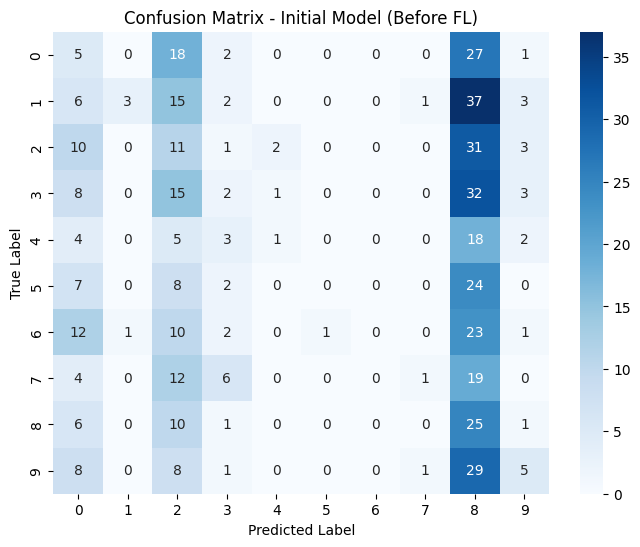

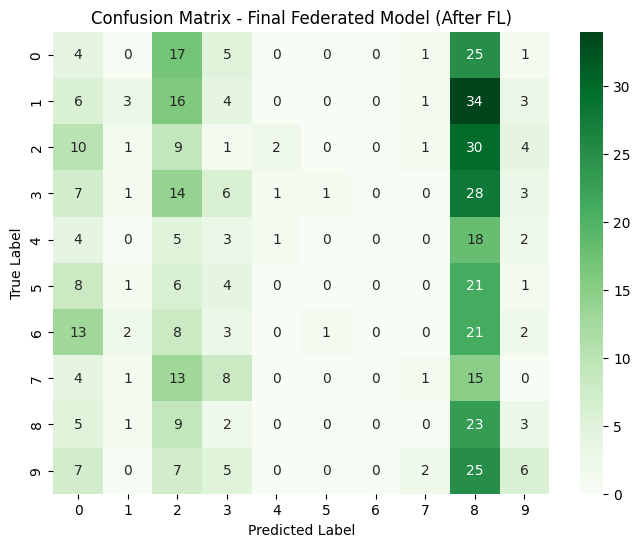


--- Accuracy Comparison ---
Initial Model Accuracy (Before FL): 0.1060
Final Federated Model Accuracy (After FL): 0.1060
Performance remained the same. This might happen with random data or insufficient training.


In [13]:
# --- Federated Learning Conceptual Example without TFF ---
# This code simulates Federated Averaging (FedAvg) using PyTorch and NumPy
# It demonstrates the core idea: local training on clients and server-side averaging of weights.
# Added: Comparison of initial model vs. final federated model using confusion matrices.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define a Simple Model (e.g., for MNIST classification) ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 128) # Flattened 28x28 image -> 128 hidden units
        self.fc2 = nn.Linear(128, 10)  # 10 classes for digits 0-9

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# --- 2. Simulate Client Data (Training Data) ---
# In a real scenario, each client would have its own private dataset.
# Here, we create dummy data for 3 clients.
num_clients = 3
client_datasets = []
num_samples_per_client = 1000
input_size = 784  # 28*28 for MNIST-like flattened images
num_classes = 10

for i in range(num_clients):
    # Generate dummy features and labels
    # Features are normalized to [0, 1]
    X = torch.rand(num_samples_per_client, input_size)
    # Labels are random integers between 0 and 9
    y = torch.randint(0, num_classes, (num_samples_per_client,))
    client_datasets.append((X, y))
    print(f"Client {i} has {num_samples_per_client} training samples.")

# --- 3. Simulate a Global Test Dataset (For Evaluation) ---
# To evaluate the models, we need a separate test set.
num_test_samples = 500
X_test = torch.rand(num_test_samples, input_size)
y_test_true = torch.randint(0, num_classes, (num_test_samples,))
print(f"Created a global test set with {num_test_samples} samples.")

# --- 4. Define Local Training Function for a Client ---
def train_client_model(client_id, model, data, epochs=5, lr=0.01):
    """Trains the model on a single client's data."""
    X, y = data
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    model.train() # Set model to training mode
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    print(f"Client {client_id} finished training. Final loss: {loss.item():.4f}")
    # Return the updated model parameters (weights)
    return model.state_dict()

# --- 5. Define Server Aggregation Function ---
def federated_average(models_state_dicts):
    """Averages the model parameters from multiple clients."""
    avg_state_dict = OrderedDict()
    num_models = len(models_state_dicts)

    # Iterate through each parameter (e.g., weight matrix, bias vector)
    for key in models_state_dicts[0].keys():
        # Stack the same parameter from all models along a new dimension
        stacked_params = torch.stack([state_dict[key] for state_dict in models_state_dicts])
        # Calculate the mean along that dimension
        avg_param = torch.mean(stacked_params, dim=0)
        avg_state_dict[key] = avg_param

    return avg_state_dict

# --- 6. Define Evaluation Function ---
def evaluate_model(model, test_data, test_labels):
    """Evaluates the model on test data and returns predictions and true labels."""
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for efficiency
        outputs = model(test_data)
        _, predicted = torch.max(outputs.data, 1) # Get the index of the max log-probability

    return predicted.numpy(), test_labels.numpy()

# --- 7. Initialize the Global Model on the server ---
global_model = SimpleNet()
print("\n--- Starting Federated Learning ---")
print(f"Global Model Architecture: {global_model}")

# --- 8. Evaluate the Initial Model (Before Training) ---
print("\n--- Evaluating Initial Global Model (Before FL) ---")
y_pred_initial, y_true_initial = evaluate_model(global_model, X_test, y_test_true)
cm_initial = confusion_matrix(y_true_initial, y_pred_initial)

# Store initial model for comparison
initial_model_state_dict = global_model.state_dict()

NUM_ROUNDS = 3

for round_num in range(NUM_ROUNDS):
    print(f"\n--- Round {round_num + 1} ---")

    # List to store updated model parameters from each client
    client_updates = []

    # Iterate through each client
    for client_id in range(num_clients):
        print(f"  Training on Client {client_id}...")

        # Create a copy of the current global model for the client
        client_model = SimpleNet()
        client_model.load_state_dict(global_model.state_dict())

        # Train the client model on its local data
        updated_state_dict = train_client_model(
            client_id=client_id,
            model=client_model,
            data=client_datasets[client_id],
            epochs=2, # Fewer epochs per round for demonstration
            lr=0.01
        )

        # Collect the updated parameters
        client_updates.append(updated_state_dict)

    # Aggregate the updates from all clients
    print("  Aggregating client updates on the server...")
    new_global_state_dict = federated_average(client_updates)

    # Update the global model with the averaged parameters
    global_model.load_state_dict(new_global_state_dict)

    print(f"  Round {round_num + 1} completed. Global model updated.")

print("\n--- Federated Learning Complete ---")
print("The global model has been updated through multiple rounds of local training and aggregation.")

# --- 9. Evaluate the Final Federated Model ---
print("\n--- Evaluating Final Federated Model (After FL) ---")
y_pred_final, y_true_final = evaluate_model(global_model, X_test, y_test_true)
cm_final = confusion_matrix(y_true_final, y_pred_final)

# --- 10. Compare Models via Confusion Matrices ---
print("\n--- Comparison: Initial Model vs. Federated Model ---")

# --- Plot Confusion Matrix for Initial Model ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm_initial, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix - Initial Model (Before FL)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Plot Confusion Matrix for Final Federated Model ---
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix - Final Federated Model (After FL)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- Calculate and Print Overall Accuracies ---
accuracy_initial = np.trace(cm_initial) / np.sum(cm_initial)
accuracy_final = np.trace(cm_final) / np.sum(cm_final)

print(f"\n--- Accuracy Comparison ---")
print(f"Initial Model Accuracy (Before FL): {accuracy_initial:.4f}")
print(f"Final Federated Model Accuracy (After FL): {accuracy_final:.4f}")

if accuracy_final > accuracy_initial:
    print(f"Performance improved by {accuracy_final - accuracy_initial:.4f}")
elif accuracy_final < accuracy_initial:
    print(f"Performance decreased by {accuracy_initial - accuracy_final:.4f}. This might happen with random data or insufficient training.")
else:
    print("Performance remained the same. This might happen with random data or insufficient training.")